# Denoising Project
*Ian Malone*

### Project Description

The purpose of this project is to design and evaluate the performance of a machine learning algorithm using the normalized LMS algorithm (or one of its variants) that will clean the desired input (speech plus noise) from the machine noise (input). This is an example of the interference canceling problem explained below.

Speech data is collected in a noisy room (loud vacuum cleaner) by two microphones: one on a table that captures speech with the vacuum cleaner noise (d(n)) and the other very close to the vacuum cleaner (n(n)) that basically has no speech. Even if you listen to d(n), the speech is barely audible, and the message is not understandable. The goal is to denoise d(n) and be able to understand the speech. It is suggested to use the signal n(n) as the input to the LMS algorithm and use d(n) as the desired response. 

### Project Steps

Start with a 2-tap filter:

 - Plots of the performance surface contours for the two weights filter case.
 - Plot the weight tracks
 - Plot the learning curve and interpret it.
 - Estimate the frequency response from the desired signal to the error when the filter is adapted.
 - Estimate the SNR improvement in dB by: 
    $ERLE=10\log(\frac{E[d^{2}]}{E[e^{2}]})$
    
Increase the filter order based on an analysis of performance. Explain your choice for the filter order.

 - Estimate again the frequency response from the desired signal to the error.
 - Compute the SNR improvement in dB
 - Evaluate the filter performance as a function of the stepsize.
 - Estimate the misadjustment.
 - Comment on the results obtained and address issues related to the convergence of the algorithm in nonstationary environments.
 
You can use a FIR filter, a gamma filter or the KLMS to compare performance. 

In [2]:
#  --------------------------
# 2 tap nLMS to denoise, mess with order a little based on some criteria, still not satisfactory
# try KLMS, look at same outputs and say that KLMS is better and why it is better (weight tracks for KLMS)
# KLMS each step you do is a new kernel center

# sys freq response is H=Y/X... FFT(error)/FFT(desired)
# may have to do fft shift to make symmetric



# do everything with NLMS and then again with KLMS that should be better
# KLMS should take in the distribution of the errors, more information than just NLMS which uses MSE (2 order moment)
# kernels and distribution gives more than an order 2 moment

# sweeps over filter order and use ERLE as criteria to define which filter order has best SNR improvement
# show graph SNR as function of filter order

### Project Implementation

In [27]:
# Import libraries

import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [29]:
# The .mat file contains two channels with data labeled as desired (d) and input (n). 

filepath = 'C:\\Users\\Ian\\Google Drive\\IanGMalone\\UF\\Classes\\ML Time Series\\Projects\\Project1\\project1.mat'
mat_data = scipy.io.loadmat(filepath)
print(mat_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'fs', 'primary', 'reference'])


In [52]:
fs = mat_data['fs']
# u is mostly noise input
# d is speech + noise desired
# error will be denoised speech

u = np.asarray(mat_data['primary'])[0,:]
d = np.asarray(mat_data['reference'])[0,:]

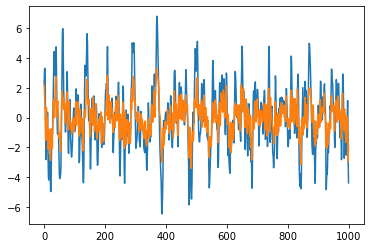

In [54]:
plt.plot(d[:1000])
plt.plot(u[:1000])



In [185]:
class LMS():
    
    def __init__(self, step_size=0.1):
        self.step_size = step_size
        
    def compute(self, u, d):
        if len(u) != len(d):
            print("Length of u does not match length of d.")
        else:
            # initialization
            w = np.zeros(len(u))
            e = np.zeros(len(u))
            
            # computation
            for i in range(1, len(u)):
                e[i] = d[i] - w[i-1] * u[i]
                w[i] = w[i-1] + self.step_size * e[i] * u[i]
        f = u.T * w
        return f, w, e


class GaussianKernel:
    def kernel(self, a, b):
        numer = (np.linalg.norm(a - b)) ** 2
        denom = (2 * self.sigma ** 2)
        return np.exp(-1 * (numer / denom))
    
    
class KLMS(GaussianKernel):
    
    def __init__(self, step_size=0.1, sigma=0.1): # num params?
        self.step_size = step_size
        self.sigma = sigma
        # inputs
        # weights        
    
    def compute(self, u, d):
        if len(u) != len(d):
            print("Length of u does not match length of d.")
        else:
            # initialization
            f = np.zeros(len(u))
            a = np.zeros(len(u))
            c = np.zeros(len(u))
            e = np.zeros(len(u))
            a[0] = self.step_size * d[0]
            c[0] = u[0]
            
            # computation
            for i in range(1, len(u)): # 1 to length of input
                for j in range(i-1): # 0 to i-1
                    f[i-1] = 0
                    partial_sum = a[j] * self.kernel(u[i], u[j])
                    f[i-1] += partial_sum                 
                    
                e[i] = d[i] - f[i-1]
                c[i] = u[i] # i think this step does not match the textbook
                a[i] = self.step_size * e[i]
        
        return f, a, c, e

In [183]:
klms_test = LMS()

In [184]:
f,w,e = klms_test.compute(u[:1000],d[:1000])

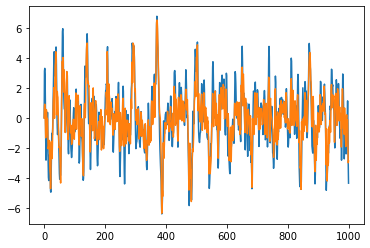

In [187]:
plt.plot(e)
plt.plot(f)
plt.plot(d[:1000])
plt.plot(a)